In [1]:
%load_ext watermark
%watermark

2019-05-15T20:26:30+02:00

CPython 3.6.5
IPython 6.4.0

compiler   : GCC 7.2.0
system     : Linux
release    : 5.0.13-arch1-1-ARCH
machine    : x86_64
processor  : 
CPU cores  : 4
interpreter: 64bit


# Analisis exploratorio de Datos

## Ingesta y procesado inicial

En esta sección vamos a hacer un ejemplo completo de como hacer un Análisis Exploratorio de Datos (EDA en inglés).

Hoy en dia no hay un proceso standard a la hora de realizar EDA, pero un proceso que a mi me gusta está basado en el proceso propuesto por Distric Data Labs ([aquí](http://blog.districtdatalabs.com/data-exploration-with-python-1) un blog post, y [aquí](https://www.youtube.com/watch?v=YEBRkLo568Q) una charla sobre el proceso).

El archivo original está en: https://www.fueleconomy.gov/feg/epadata/vehicles.csv.zip
El archivo que vamos a usar es una versión modificada (con menos columnas)

Descripcion del dataset
http://www.fueleconomy.gov/feg/ws/index.shtml#ft7


Supongamos que somos la agencia de porteccion ambiental americana, la EPA. Uno de sus trabajos es analizar los coches nuevos que se venden en EEUU y estudiar su contaminacion.

In [2]:
import pandas as pd

In [3]:
%matplotlib notebook

### Lectura de datos


In [6]:
vehiculos = pd.read_csv("data/vehiculos-original.csv")

In [7]:
vehiculos.shape

(38436, 11)

In [8]:
vehiculos.head()

,make,model,year,displ,cylinders,trany,drive,VClass,fuelType,comb08,co2TailpipeGpm
0,AM General,DJ Po Vehicle 2WD,1984,2.5,4.0,Automatic 3-spd,2-Wheel Drive,Special Purpose Vehicle 2WD,Regular,17,522.764706
1,AM General,DJ Po Vehicle 2WD,1984,2.5,4.0,Automatic 3-spd,2-Wheel Drive,Special Purpose Vehicle 2WD,Regular,17,522.764706
2,AM General,FJ8c Post Office,1984,4.2,6.0,Automatic 3-spd,2-Wheel Drive,Special Purpose Vehicle 2WD,Regular,13,683.615385
3,AM General,FJ8c Post Office,1984,4.2,6.0,Automatic 3-spd,2-Wheel Drive,Special Purpose Vehicle 2WD,Regular,13,683.615385
4,AM General,Post Office DJ5 2WD,1985,2.5,4.0,Automatic 3-spd,Rear-Wheel Drive,Special Purpose Vehicle 2WD,Regular,16,555.437500


Es conveniente renombrar las columnas y darles un nombre descriptivo

In [9]:
vehiculos = vehiculos.rename(columns={
    "cylinders":"cilindros",
    "trany":"transmision",
    "make":"fabricante",
    "model":"modelo",
    "displ":"desplazamiento", #volumen de desplazamiento del motor
    "drive":"traccion",
    "VClass":"clase",
    "fuelType":"combustible",
    "comb08":"consumo", #combined MPG for fuelType1
    "co2TailpipeGpm":"co2", # tailpipe CO2 in grams/mile
})

In [10]:
vehiculos.head()

,fabricante,modelo,year,desplazamiento,cilindros,transmision,traccion,clase,combustible,consumo,co2
0,AM General,DJ Po Vehicle 2WD,1984,2.5,4.0,Automatic 3-spd,2-Wheel Drive,Special Purpose Vehicle 2WD,Regular,17,522.764706
1,AM General,DJ Po Vehicle 2WD,1984,2.5,4.0,Automatic 3-spd,2-Wheel Drive,Special Purpose Vehicle 2WD,Regular,17,522.764706
2,AM General,FJ8c Post Office,1984,4.2,6.0,Automatic 3-spd,2-Wheel Drive,Special Purpose Vehicle 2WD,Regular,13,683.615385
3,AM General,FJ8c Post Office,1984,4.2,6.0,Automatic 3-spd,2-Wheel Drive,Special Purpose Vehicle 2WD,Regular,13,683.615385
4,AM General,Post Office DJ5 2WD,1985,2.5,4.0,Automatic 3-spd,Rear-Wheel Drive,Special Purpose Vehicle 2WD,Regular,16,555.437500


In [11]:
vehiculos.dtypes

fabricante         object
modelo             object
year                int64
desplazamiento    float64
cilindros         float64
transmision        object
traccion           object
clase              object
combustible        object
consumo             int64
co2               float64
dtype: object

**¿Cual es el objetivo de este análisis?**

Un aspecto importante que me gusta siempre tener claro al empezar un EDA es saber el objetivo del mismo. Generalmente hay una lista de preguntas concretas que responder, o al menos las personas a cargo de recolectar el dataset lo crearon con un objetivo en mente.

En este caso, uno de los objetivos por los cuales la EPA crea este dataset es para controlar lo que contamina cada coche, en este caso la variable co2

### Descripción de la entidad.
- fabricante
- fabricante-modelo
- fabricante-model-año
- fabricante-año

### Exportación a csv:



In [13]:
vehiculos.to_csv("data/vehiculos.1.procesado_inicial.csv", index=False)

## Diagnostico de calidad de los datos (QA)

matplotlib notebook, es muy util para hacer plots mas visibles, pero es un poco complicada de usar ya que requiere el cerrar cada plot para poder continuar.

Alternativamente, se puede usar %matplotlib inline, que es más sencilla ya que simplemente muestra el gráfico original en el jupyter notebook. Para modificar el tamaño de los plots en este caso basta con cambiar el parámetro general de matplotlib figure.figsize al tamaño de gráfico deseado (en pulgadas)


In [14]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (12,12) # 10 pulgadas de ancho y 10 de alto para todos los plots

En este apartado vamos a revisar el dataset. El objetivo sera tener un dataset lo mas parecido al original pero sin fallos en el mismo que puedan llevarnos a sacar conclusiones erroneas.

El input de este paso es el output del anterior

In [16]:
vehiculos = pd.read_csv("data/vehiculos.1.procesado_inicial.csv")

In [17]:
vehiculos.shape

(38436, 11)

### Duplicados

En este apartado se intentan ver dos cosas:

* Asegurarse de que datos que no debieran estar duplicados no lo están (por ejemplo, numeros de telefono)

* Revisar  si hay columnas que tengan un alto numero de duplicados, ya que pueden no aportar mucha informacion

Recordemos que las entidades posibles eran:   
    
    fabricante
    fabricante-modelo
    fabricante-modelo-año
    fabricante-año

De estas entidades, las unicas que no se deberian repetir coches especificos, es decir, fabricante+modelo +año

In [18]:
vehiculos['modelo_unico'] = vehiculos.fabricante.str.cat([vehiculos.modelo, vehiculos.year.apply(str)],sep='-')

In [19]:
vehiculos.modelo_unico.value_counts()

Jeep-Cherokee/Wagoneer-1985               24
Ford-F150 Pickup 2WD-1984                 19
Chevrolet-C10 Pickup 2WD-1984             19
GMC-C15 Pickup 2WD-1984                   19
Chevrolet-C10 Pickup 2WD-1985             18
Chevrolet-S10 Pickup 2WD-1984             18
GMC-C15 Pickup 2WD-1985                   18
GMC-S15 Pickup 2WD-1984                   18
Chevrolet-C10 Pickup 2WD-1986             17
Ford-Ranger Pickup 2WD-1984               17
Mitsubishi-Truck 2WD-1984                 17
Dodge-Ram 50 Pickup 2WD-1984              17
GMC-C15 Pickup 2WD-1986                   17
Mercury-Lynx-1984                         16
Volkswagen-Rabbit-1984                    16
GMC-Vandura G15/25 2WD-1984               16
Ford-Escort-1984                          16
Ford-F150 Pickup 2WD-1985                 16
Ford-Escort-1985                          16
Chevrolet-G10/20 Van 2WD-1984             16
Ford-F150 Pickup 4WD-1984                 15
Ford-Bronco 4WD-1984                      15
Ford-E150 

Nos damos cuenta de que hay muchos repetidos, veamos un ejemplo

In [20]:
vehiculos[vehiculos.modelo_unico=='Chevrolet-C1500 Pickup 2WD-1991'].head()

,fabricante,modelo,year,desplazamiento,cilindros,transmision,traccion,clase,combustible,consumo,co2,modelo_unico
4957,Chevrolet,C1500 Pickup 2WD,1991,4.3,6.0,Automatic 4-spd,Rear-Wheel Drive,Standard Pickup Trucks,Regular,17,522.764706,Chevrolet-C1500 Pickup 2WD-1991
4958,Chevrolet,C1500 Pickup 2WD,1991,4.3,6.0,Manual 4-spd,Rear-Wheel Drive,Standard Pickup Trucks,Regular,17,522.764706,Chevrolet-C1500 Pickup 2WD-1991
4959,Chevrolet,C1500 Pickup 2WD,1991,4.3,6.0,Manual 5-spd,Rear-Wheel Drive,Standard Pickup Trucks,Regular,17,522.764706,Chevrolet-C1500 Pickup 2WD-1991
4960,Chevrolet,C1500 Pickup 2WD,1991,4.3,6.0,Manual 5-spd,Rear-Wheel Drive,Standard Pickup Trucks,Regular,17,522.764706,Chevrolet-C1500 Pickup 2WD-1991
4961,Chevrolet,C1500 Pickup 2WD,1991,5.0,8.0,Automatic 4-spd,Rear-Wheel Drive,Standard Pickup Trucks,Regular,15,592.466667,Chevrolet-C1500 Pickup 2WD-1991


Como vemos , cada modelo unico tiene diferentes configuraciones de cada coche (3 velocidades o 4 por ejemplo)
Por lo tanto, solo vamos a considerar duplicados aquellos records que sean idénticos en todas sus columnas

In [21]:
vehiculos[vehiculos.duplicated()].shape

(1506, 12)

Vemos que hay 1506 records duplicados, podemos eliminarlos para el resto del análisis ya que pueden distorsionar las conclusiones

In [22]:
vehiculos = vehiculos.drop_duplicates()
vehiculos.shape

(36930, 12)

Borramos la columna `modelo_unico`

In [23]:
del vehiculos['modelo_unico']

Ahora falta ver si hay variables en las que haya una gran cantidad de registros que tengan el mismo valor (cardinalidad).

In [24]:
n_records = len(vehiculos)
def valores_duplicados_col(df):
    for columna in df:
        n_por_valor = df[columna].value_counts()
        mas_comun = n_por_valor.iloc[0]
        menos_comun = n_por_valor.iloc[-1]
        print("{} | {}-{} | {}".format(
            df[columna].name,
            round(mas_comun / (1.0*n_records),3),
            round(menos_comun / (1.0*n_records),3),
            df[columna].dtype
        ))

valores_duplicados_col(vehiculos)

fabricante | 0.1-0.0 | object
modelo | 0.005-0.0 | object
year | 0.038-0.007 | int64
desplazamiento | 0.095-0.0 | float64
cilindros | 0.38-0.0 | float64
transmision | 0.287-0.0 | object
traccion | 0.353-0.005 | object
clase | 0.145-0.0 | object
combustible | 0.652-0.0 | object
consumo | 0.097-0.0 | int64
co2 | 0.084-0.0 | float64


Vemos que los campos `traccion, transmission, cilindros y combustible` pueden tener un problema de valores repetidos, en realidad 30% no es algo muy dramatico, seria distinto si el valor mas comun tuviera un 90%.

In [25]:
vehiculos.traccion.value_counts(normalize=True)

Front-Wheel Drive             0.360280
Rear-Wheel Drive              0.352863
4-Wheel or All-Wheel Drive    0.177345
All-Wheel Drive               0.062325
4-Wheel Drive                 0.030886
2-Wheel Drive                 0.011402
Part-time 4-Wheel Drive       0.004899
Name: traccion, dtype: float64

Vemos que esto tiene sentido, ya que la inmensa mayoria de vehiculos tienen traccion a dos ruedas, sean delanteras o traseras. 

En este caso alguien con conocimiento de dominio podria darse cuenta de que probablemente 2-Wheel Drive sea simplemente una clasificacion distinta de Front o Rear. 

https://www.edmunds.com/car-technology/what-wheel-drive.html

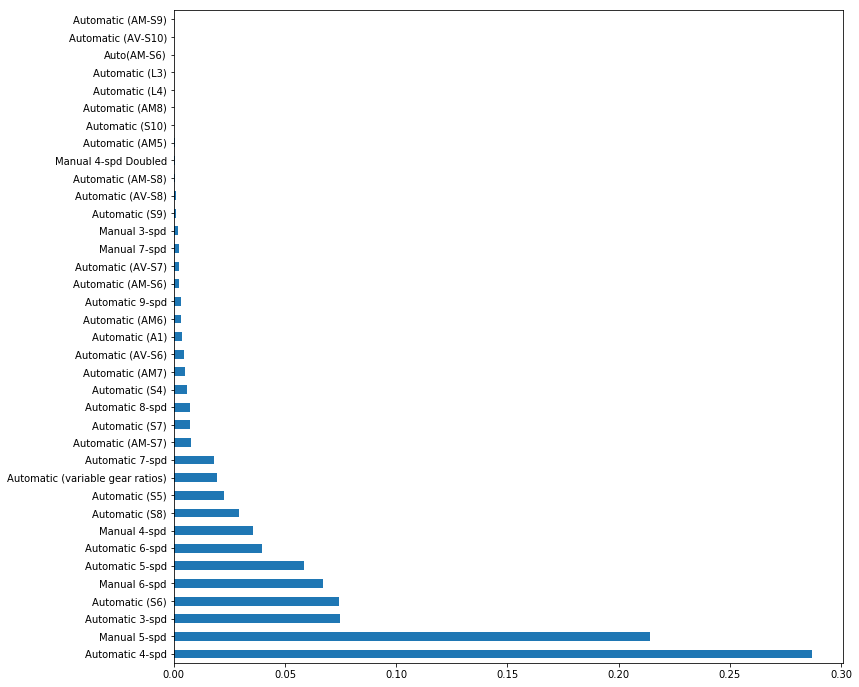

In [26]:
vehiculos.transmision.value_counts(normalize=True).plot.barh();

Vemos que aunque transmisión tenga una cardinalidad relativamente alta, en realidad muestra una distribución de tipos, con dos clases mayoritarias

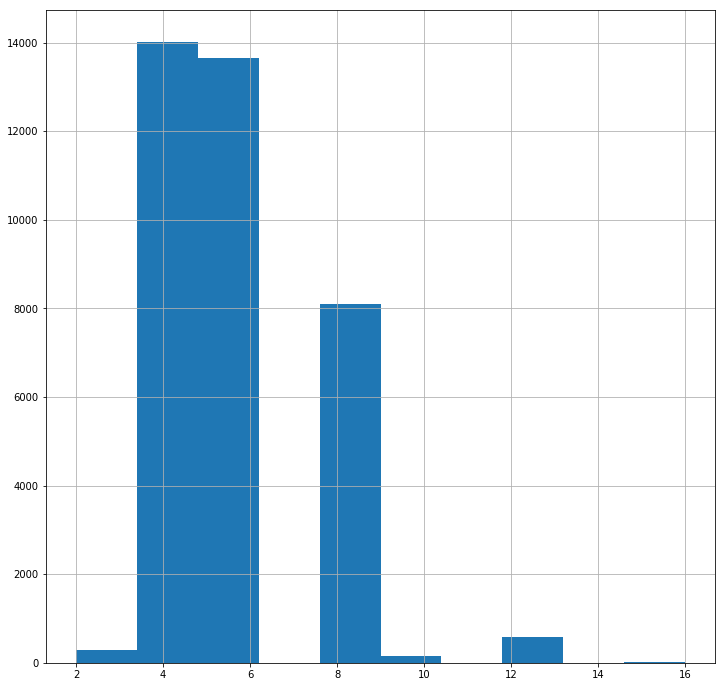

In [27]:
vehiculos.cilindros.hist();

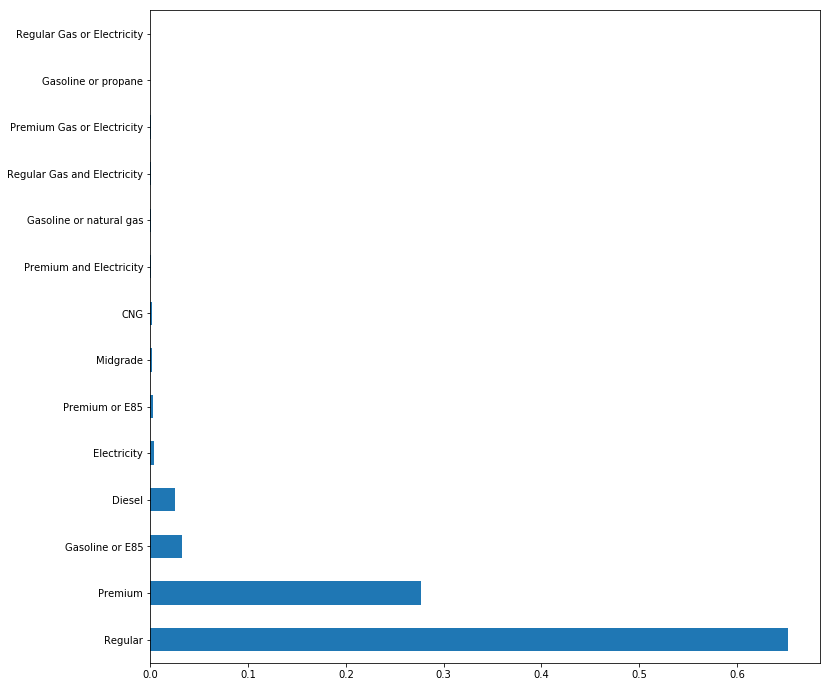

In [28]:
vehiculos.combustible.value_counts(normalize=True).plot.barh();

Vemos que la columna `combustible` si puede tener un problema al tener el 65% de los casos gasolina `Regular`

### Valores inexistentes

In [29]:
n_records = len(vehiculos)
def valores_inexistentes_col(df):
    for columna in df:
        print("{} | {} | {}".format(
            df[columna].name, len(df[df[columna].isnull()]) / (1.0*n_records), df[columna].dtype
        ))

valores_inexistentes_col(vehiculos)

fabricante | 0.0 | object
modelo | 0.0 | object
year | 0.0 | int64
desplazamiento | 0.0037909558624424585 | float64
cilindros | 0.003845112374763065 | float64
transmision | 0.00029786081776333605 | object
traccion | 0.02158137015976171 | object
clase | 0.0 | object
combustible | 0.0 | object
consumo | 0.0 | int64
co2 | 0.0 | float64


Vemos que campo `traccion, cilindros y transmision` tienen valores inexistentes. Sin embargo son cantidades despreciables (maximo es la variable traccion con un 3% inexistente)



### Valores extremos (Outliers)
Para detectar valores extremos una medida general es considerar outliers aquellos valores con una puntuación Z (z score) mayor de 3, esto es, que se alejan 3 veces o mas desviaciones standard de la media.

El z score se define como:

$$z(x)= \frac{x-\mu}{\sigma}$$

In [30]:
from scipy import stats
import numpy as np

def outliers_col(df):
    for columna in df:
        if df[columna].dtype != np.object:
            n_outliers = len(df[np.abs(stats.zscore(df[columna])) > 3])    
            print("{} | {} | {}".format(
                df[columna].name,
                n_outliers,
                df[columna].dtype
        ))

outliers_col(vehiculos)

year | 0 | int64
desplazamiento | 0 | float64
cilindros | 0 | float64
consumo | 233 | int64
co2 | 358 | float64


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys


Vemos que las variables de consumo y co2 tienen outliers. Podemos hacer un boxplot para visualizar esto mejor

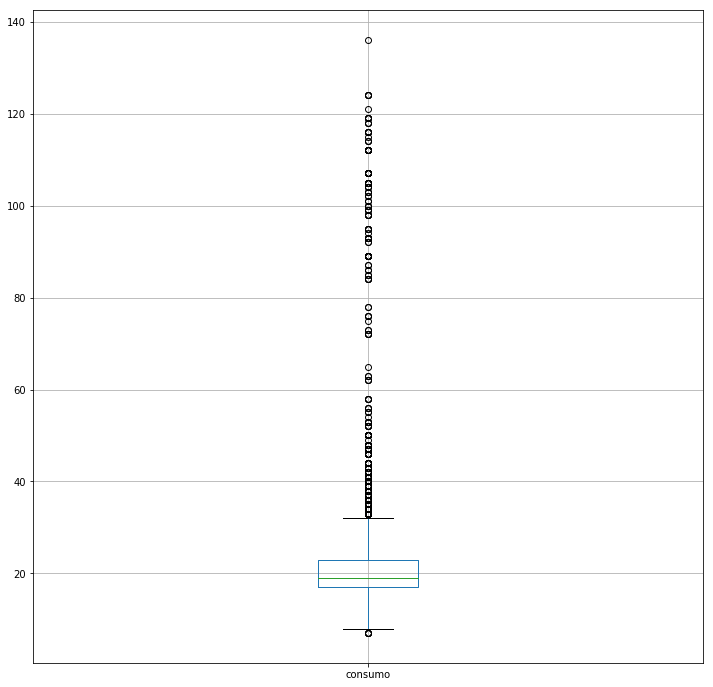

In [31]:
vehiculos.boxplot(column='consumo');

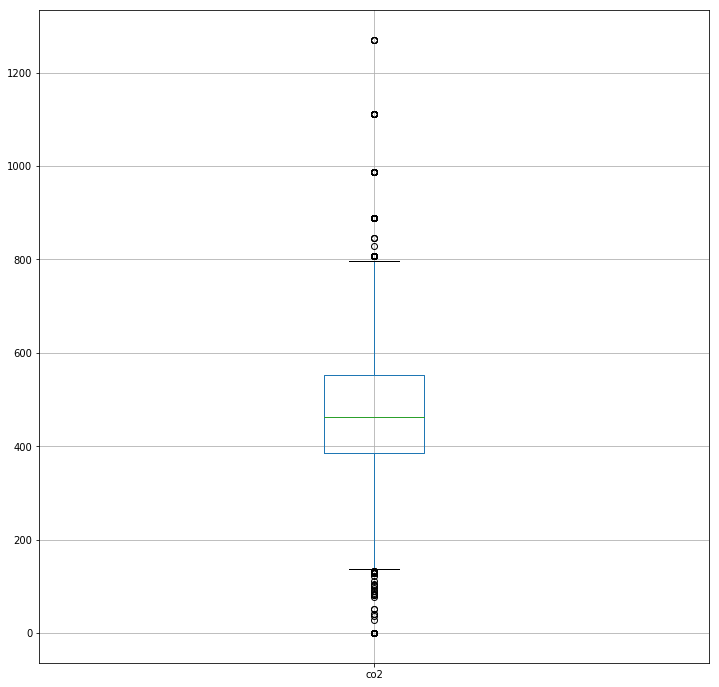

In [32]:
vehiculos.boxplot(column='co2');

Vemos que en cuanto a consumo hay algunos coches que contaminan mas de lo normal y otros que contaminan menos de lo normal, tambien vemos que hay coches que no contaminan nada!

Es posible que haya coches que no usen gasolina en el dataset?

In [33]:
vehiculos[vehiculos.co2==0].combustible.unique()

array(['Electricity'], dtype=object)

In [34]:
vehiculos.combustible.unique()

array(['Regular', 'Premium', 'Diesel', 'Premium and Electricity',
       'Premium or E85', 'Electricity', 'Premium Gas or Electricity',
       'Gasoline or E85', 'Gasoline or natural gas', 'CNG',
       'Regular Gas or Electricity', 'Midgrade',
       'Regular Gas and Electricity', 'Gasoline or propane'], dtype=object)

Vemos que en este dataset hay vehiculos hibridos y vehiculos electricos puros. Dado que el objetivo es la contaminacion, convendria remover al menos aquellos vehiculos que no contaminan

In [35]:
vehiculos_no_electricos = vehiculos[vehiculos.co2>0]

Ya que hemos descubierto esto, volvamos a revisar los datos con el nuevo dataset

In [36]:
outliers_col(vehiculos_no_electricos)

year | 0 | int64
desplazamiento | 0 | float64
cilindros | 0 | float64
consumo | 400 | int64
co2 | 221 | float64


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys


Vemos que siguen habiendo outliers en cuanto a consumo y co2. ¿Será por que los vehículos híbridos consumen menos? Si fuera por esto estos valores extremos son valores perfectamente válidos y por tanto no deberíamos eliminarlos

In [37]:
vehiculos_no_electricos[
    np.abs(stats.zscore(vehiculos_no_electricos["consumo"])) > 3
].combustible.value_counts(normalize=True)

Regular                        0.7175
Diesel                         0.1525
Premium                        0.0550
Regular Gas and Electricity    0.0475
Premium Gas or Electricity     0.0200
Regular Gas or Electricity     0.0050
Premium and Electricity        0.0025
Name: combustible, dtype: float64

Vemos que no es el caso, que hay outliers en un rango de combustibles tanto híbridos como no híbridos. Asi que son outliers reales.

In [38]:
valores_duplicados_col(vehiculos_no_electricos)

fabricante | 0.099-0.0 | object
modelo | 0.005-0.0 | object
year | 0.038-0.007 | int64
desplazamiento | 0.095-0.0 | float64
cilindros | 0.38-0.0 | float64
transmision | 0.287-0.0 | object
traccion | 0.351-0.005 | object
clase | 0.145-0.0 | object
combustible | 0.652-0.0 | object
consumo | 0.097-0.0 | int64
co2 | 0.084-0.0 | float64


### Valores inexistentes

In [39]:
valores_inexistentes_col(vehiculos)

fabricante | 0.0 | object
modelo | 0.0 | object
year | 0.0 | int64
desplazamiento | 0.0037909558624424585 | float64
cilindros | 0.003845112374763065 | float64
transmision | 0.00029786081776333605 | object
traccion | 0.02158137015976171 | object
clase | 0.0 | object
combustible | 0.0 | object
consumo | 0.0 | int64
co2 | 0.0 | float64


Ahora vemos que no hay valores inexistentes extremos en ninguna variable. La variable con mayor numero de valores inexistentes es traccion (2%). Obviamente, los coches electricos no tienen motor de gasolina y por tanto, no tienen cilindros.

### Conclusion
- Hay 1506 records duplicados (los hemos removido)
- las variables `desplazamiento, cilindros, transmision y traccion tienen valores inexistentes`
- La variable `combustible` tiene una clase dominante (65% de coches tienen combustible `Regular`)
- hay un outlier en las variables `co2` y `consumo`
- Hay coches hibridos y coches electricos (hemos removido estos ultimos ya que no contaminan).

### Exportamos el trabajo

In [41]:
vehiculos_no_electricos.to_csv("data/vehiculos.2.limpio_analisis.csv", index=False)

## Agrupacion de variables

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (12,12) # 10 pulgadas de ancho y 10 de alto para todos los plots

### Ingesta de Datos

In [43]:
vehiculos = pd.read_csv("data/vehiculos.2.limpio_analisis.csv")

In [44]:
vehiculos.head()

,fabricante,modelo,year,desplazamiento,cilindros,transmision,traccion,clase,combustible,consumo,co2
0,AM General,DJ Po Vehicle 2WD,1984,2.5,4.0,Automatic 3-spd,2-Wheel Drive,Special Purpose Vehicle 2WD,Regular,17,522.764706
1,AM General,FJ8c Post Office,1984,4.2,6.0,Automatic 3-spd,2-Wheel Drive,Special Purpose Vehicle 2WD,Regular,13,683.615385
2,AM General,Post Office DJ5 2WD,1985,2.5,4.0,Automatic 3-spd,Rear-Wheel Drive,Special Purpose Vehicle 2WD,Regular,16,555.437500
3,AM General,Post Office DJ8 2WD,1985,4.2,6.0,Automatic 3-spd,Rear-Wheel Drive,Special Purpose Vehicle 2WD,Regular,13,683.615385
4,ASC Incorporated,GNX,1987,3.8,6.0,Automatic 4-spd,Rear-Wheel Drive,Midsize Cars,Premium,16,555.437500


En este paso vamos a agregar aquellas variables que se puedan agrupar en tipos más genéricos. Esto ayuda a analizarlos por grupos en vez de por elementos individuales.

Para ello podemos ver el numero de valores distintos que cada variable categorica tiene

In [45]:
def unique_col_values(df):
    for column in df:
        print("{} | {} | {}".format(
            df[column].name, len(df[column].unique()), df[column].dtype
        ))

unique_col_values(vehiculos)

fabricante | 129 | object
modelo | 3734 | object
year | 35 | int64
desplazamiento | 66 | float64
cilindros | 10 | float64
transmision | 38 | object
traccion | 8 | object
clase | 34 | object
combustible | 13 | object
consumo | 49 | int64
co2 | 596 | float64


### Agrupacion de variables categoricas

#### Clase de vehiculo

In [46]:
vehiculos.clase.unique()

array(['Special Purpose Vehicle 2WD', 'Midsize Cars', 'Subcompact Cars',
       'Compact Cars', 'Sport Utility Vehicle - 4WD',
       'Small Sport Utility Vehicle 2WD',
       'Small Sport Utility Vehicle 4WD', 'Two Seaters',
       'Sport Utility Vehicle - 2WD', 'Special Purpose Vehicles',
       'Special Purpose Vehicle 4WD', 'Small Station Wagons',
       'Minicompact Cars', 'Midsize-Large Station Wagons',
       'Midsize Station Wagons', 'Large Cars',
       'Standard Sport Utility Vehicle 4WD',
       'Standard Sport Utility Vehicle 2WD', 'Minivan - 4WD',
       'Minivan - 2WD', 'Vans', 'Vans, Cargo Type',
       'Vans, Passenger Type', 'Standard Pickup Trucks 2WD',
       'Standard Pickup Trucks', 'Standard Pickup Trucks/2wd',
       'Small Pickup Trucks 2WD', 'Standard Pickup Trucks 4WD',
       'Small Pickup Trucks 4WD', 'Small Pickup Trucks', 'Vans Passenger',
       'Special Purpose Vehicle', 'Special Purpose Vehicles/2wd',
       'Special Purpose Vehicles/4wd'], dtype=object

In [47]:
pequeno = ['Compact Cars','Subcompact Cars','Two Seaters','Minicompact Cars']
medio = ['Midsize Cars']
grande = ['Large Cars']

vehiculos.loc[vehiculos['clase'].isin(pequeno), 
             'clase_tipo'] = 'Coches pequeños'

vehiculos.loc[vehiculos['clase'].isin(medio), 
             'clase_tipo'] = 'Coches Medianos'

vehiculos.loc[vehiculos['clase'].isin(grande), 
             'clase_tipo'] = 'Coches Grandes'

vehiculos.loc[vehiculos['clase'].str.contains('Truck'), 
             'clase_tipo'] = 'Camionetas'

vehiculos.loc[vehiculos['clase'].str.contains('Special Purpose'), 
             'clase_tipo'] = 'Vehículos Especiales'

vehiculos.loc[vehiculos['clase'].str.contains('Sport Utility'), 
             'clase_tipo'] = 'Deportivos'

vehiculos.loc[vehiculos['clase'].str.contains('Station'), 
             'clase_tipo'] = 'Coche Familiar'

vehiculos.loc[(vehiculos['clase'].str.lower().str.contains('van')),
             'clase_tipo'] = 'Furgoneta'

In [48]:
vehiculos.clase_tipo = vehiculos.clase_tipo.astype("category")

In [49]:
vehiculos.clase_tipo.dtype

CategoricalDtype(categories=['Camionetas', 'Coche Familiar', 'Coches Grandes',
                  'Coches Medianos', 'Coches pequeños', 'Deportivos',
                  'Furgoneta', 'Vehículos Especiales'],
                 ordered=False)

In [50]:
vehiculos.clase_tipo.value_counts()

Coches pequeños         13007
Camionetas               5439
Deportivos               5289
Coches Medianos          4261
Coche Familiar           2533
Vehículos Especiales     2214
Furgoneta                2211
Coches Grandes           1837
Name: clase_tipo, dtype: int64

#### Traccion


In [61]:
vehiculos.traccion.unique()

array(['2-Wheel Drive', 'Rear-Wheel Drive', 'Front-Wheel Drive',
       '4-Wheel or All-Wheel Drive', 'All-Wheel Drive', nan,
       '4-Wheel Drive', 'Part-time 4-Wheel Drive'], dtype=object)

In [62]:
vehiculos["traccion_tipo"] = "dos"
vehiculos["traccion_tipo"][vehiculos.traccion.isin([
    "4-Wheel or All-Wheel Drive", "All-Wheel Drive",
    "4-Wheel Drive", "Part-time 4-Wheel Drive"
])] = "cuatro"

Este warning es un warning de que estamos alterando una copia de vehicles (vehicles_year), no vehicles.

para deshabilitar se puede utilizar:

In [63]:
pd.set_option('chained_assignment',None)

o simplemente usar `loc` para asignar valores en pandas

In [64]:
vehiculos["traccion_tipo"] = "dos"

vehiculos.loc[vehiculos.traccion.isin([
    "4-Wheel or All-Wheel Drive", "All-Wheel Drive",
    "4-Wheel Drive", "Part-time 4-Wheel Drive"
]), "traccion_tipo"] = "cuatro"

Pandas tiene un dtype especial para variables categoricas llamado `category`. El especificar a pandas que un campo es una categoria en vez de un object (un string generalmente) amplia las funcionalidades que podemos usar.Además, las categorias en general ocupan menos espacio en memoria (si su cardinalidad no es muy elevada).

In [65]:
vehiculos.traccion_tipo = vehiculos.traccion_tipo.astype("category")

#### Transmision

In [66]:
vehiculos.transmision.unique()

array(['Automatic 3-spd', 'Automatic 4-spd', 'Manual 5-spd',
       'Automatic (S5)', 'Manual 6-spd', 'Automatic 5-spd',
       'Automatic (AM8)', 'Automatic (AM-S8)', 'Automatic (AV-S7)',
       'Automatic (S6)', 'Automatic (S9)', 'Automatic (AM-S7)',
       'Automatic (S4)', 'Automatic (AM-S9)', 'Automatic (S7)',
       'Automatic (AM7)', 'Automatic (AM6)', 'Automatic 6-spd',
       'Automatic 8-spd', 'Manual 4-spd', 'Automatic (S8)',
       'Manual 7-spd', 'Automatic (AM-S6)', 'Auto(AM-S6)',
       'Automatic (variable gear ratios)', 'Automatic (AV-S8)',
       'Automatic (A1)', 'Automatic (AV-S6)', 'Manual 3-spd',
       'Automatic (S10)', 'Automatic 9-spd', 'Manual 4-spd Doubled', nan,
       'Automatic (L4)', 'Automatic (L3)', 'Automatic (AV-S10)',
       'Automatic 7-spd', 'Automatic (AM5)'], dtype=object)

Vemos que las transmisiones se pueden agregar en manual o automatica

In [70]:
vehiculos['transmision_tipo'] = "Automatica"
vehiculos['transmision_tipo'][
    (vehiculos['transmision'].notnull()) & (vehiculos['transmision'].str.startswith('M'))
] = "Manual"

In [71]:
vehiculos.transmision_tipo = vehiculos.transmision_tipo.astype("category")

In [73]:
vehiculos.transmision_tipo.value_counts()

Automatica    24937
Manual        11854
Name: transmision_tipo, dtype: int64

##### Combustible


In [74]:
vehiculos.combustible.value_counts()

Regular                        24078
Premium                        10206
Gasoline or E85                 1215
Diesel                           933
Premium or E85                   124
Midgrade                          77
CNG                               60
Premium and Electricity           30
Gasoline or natural gas           20
Regular Gas and Electricity       20
Premium Gas or Electricity        18
Gasoline or propane                8
Regular Gas or Electricity         2
Name: combustible, dtype: int64

In [75]:
vehiculos['combustible_tipo'] = 'Otros tipos de combustible'
vehiculos.loc[vehiculos['combustible']=='Regular',
             'combustible_tipo'] = 'Normal'
vehiculos.loc[vehiculos['combustible']=='Premium',
             'combustible_tipo'] = 'Premium'

vehiculos.loc[vehiculos['combustible'].str.contains('Electricity'),
             'combustible_tipo'] = 'Hibrido'

In [76]:
vehiculos.combustible_tipo = vehiculos.combustible_tipo.astype("category")

In [77]:
vehiculos.combustible_tipo.value_counts()

Normal                        24078
Premium                       10206
Otros tipos de combustible     2437
Hibrido                          70
Name: combustible_tipo, dtype: int64

In [78]:
vehiculos.head()

,fabricante,modelo,year,desplazamiento,cilindros,transmision,traccion,clase,combustible,consumo,co2,clase_tipo,traccion_tipo,transmision_tipo,combustible_tipo
0,AM General,DJ Po Vehicle 2WD,1984,2.5,4.0,Automatic 3-spd,2-Wheel Drive,Special Purpose Vehicle 2WD,Regular,17,522.764706,Vehículos Especiales,dos,Automatica,Normal
1,AM General,FJ8c Post Office,1984,4.2,6.0,Automatic 3-spd,2-Wheel Drive,Special Purpose Vehicle 2WD,Regular,13,683.615385,Vehículos Especiales,dos,Automatica,Normal
2,AM General,Post Office DJ5 2WD,1985,2.5,4.0,Automatic 3-spd,Rear-Wheel Drive,Special Purpose Vehicle 2WD,Regular,16,555.437500,Vehículos Especiales,dos,Automatica,Normal
3,AM General,Post Office DJ8 2WD,1985,4.2,6.0,Automatic 3-spd,Rear-Wheel Drive,Special Purpose Vehicle 2WD,Regular,13,683.615385,Vehículos Especiales,dos,Automatica,Normal
4,ASC Incorporated,GNX,1987,3.8,6.0,Automatic 4-spd,Rear-Wheel Drive,Midsize Cars,Premium,16,555.437500,Coches Medianos,dos,Automatica,Premium


### Agrupar variables continuas.

Una manera sencilla de convertir variables continuas en otras categoricas es mediante el uso de quintiles.

In [79]:
tipos_tamaño_motor = ['muy pequeño',"pequeño",  "mediano", "grande", "muy grande"]

vehiculos['tamano_motor_tipo'] = pd.qcut(vehiculos['desplazamiento'],
                                  5, tipos_tamaño_motor)

In [80]:
tipos_consumo = ['muy bajo', 'bajo', 'moderado', 'alto', 'muy alto']

vehiculos['consumo_tipo'] = pd.qcut(vehiculos['consumo'],
                                  5, tipos_consumo)

In [81]:
tipos_co2 = ['muy bajo', 'bajo', 'moderado', 'alto', 'muy alto']

vehiculos['co2_tipo'] = pd.qcut(vehiculos['co2'],
                                  5, tipos_co2)

In [82]:
vehiculos.head()

,fabricante,modelo,year,desplazamiento,cilindros,transmision,traccion,clase,combustible,consumo,co2,clase_tipo,traccion_tipo,transmision_tipo,combustible_tipo,tamano_motor_tipo,consumo_tipo,co2_tipo
0,AM General,DJ Po Vehicle 2WD,1984,2.5,4.0,Automatic 3-spd,2-Wheel Drive,Special Purpose Vehicle 2WD,Regular,17,522.764706,Vehículos Especiales,dos,Automatica,Normal,pequeño,bajo,alto
1,AM General,FJ8c Post Office,1984,4.2,6.0,Automatic 3-spd,2-Wheel Drive,Special Purpose Vehicle 2WD,Regular,13,683.615385,Vehículos Especiales,dos,Automatica,Normal,grande,muy bajo,muy alto
2,AM General,Post Office DJ5 2WD,1985,2.5,4.0,Automatic 3-spd,Rear-Wheel Drive,Special Purpose Vehicle 2WD,Regular,16,555.437500,Vehículos Especiales,dos,Automatica,Normal,pequeño,muy bajo,alto
3,AM General,Post Office DJ8 2WD,1985,4.2,6.0,Automatic 3-spd,Rear-Wheel Drive,Special Purpose Vehicle 2WD,Regular,13,683.615385,Vehículos Especiales,dos,Automatica,Normal,grande,muy bajo,muy alto
4,ASC Incorporated,GNX,1987,3.8,6.0,Automatic 4-spd,Rear-Wheel Drive,Midsize Cars,Premium,16,555.437500,Coches Medianos,dos,Automatica,Premium,grande,muy bajo,alto


Al ver las primeras filas spuede ver algo raro. Se observa que tipo_consumo y tipo_co2 estan correlacionadas negativamente. Es decir, para cada coche, aquellos con un consumo bajo tienen un co2 alto y viceversa. Sin ser un experto en coches, la lógica me diria lo contrario, es decir, que aquellos coches que mas gasolina consumen son aquellos que mas contaminan.

En este momento lo mejor es visualizar la relacion de dichas variables y ver como están relacionadas. Éste es un ejemplo de como el EDA no es un proceso lineal.

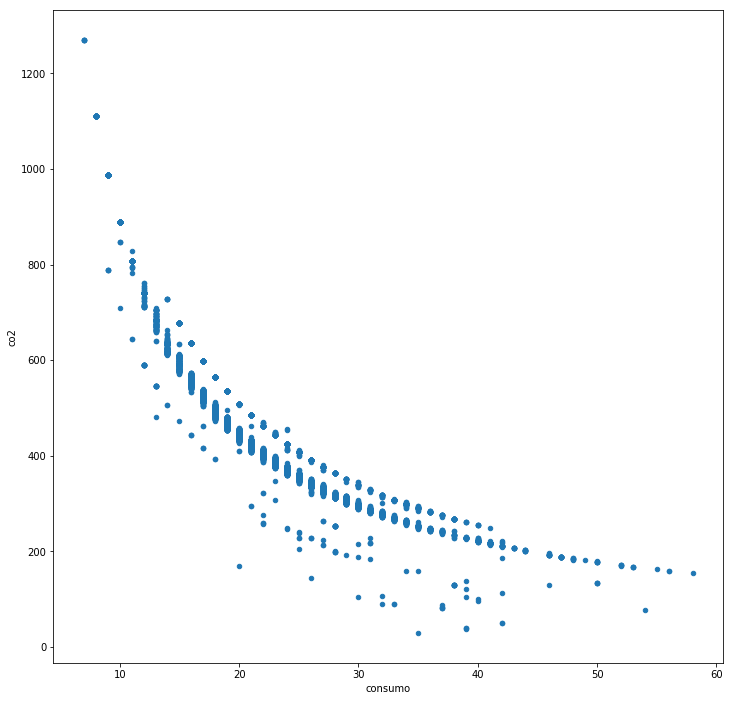

In [83]:
vehiculos.plot.scatter(x="consumo",y="co2")

En la descripción del dataset, se ve que CO2 se mide en gramos por milla, mientras que el consumo se mide en millas por gallon.

Lo que debemos hacer es convertir el consumo a galones por milla y asi ambas variables son relativas a la milla y podemos compararlas.

In [84]:
litros_por_galon =  3.78541

vehiculos["consumo_litros_milla"] = litros_por_galon/ vehiculos.consumo

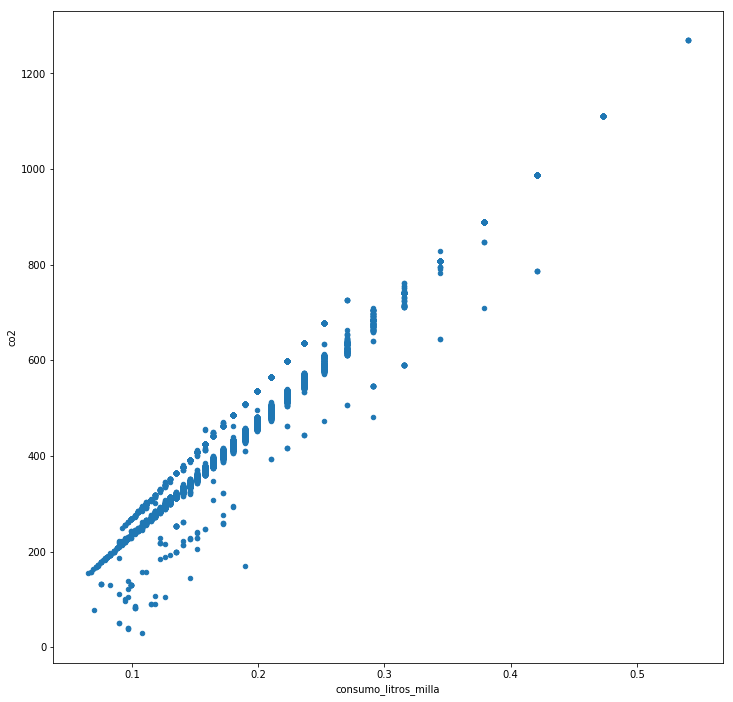

In [85]:
vehiculos.plot.scatter(x="consumo_litros_milla",y="co2");

Se vuelve a calcular los niveles de consumo con la nueva variable

In [86]:
tipos_consumo = ['muy bajo', 'bajo', 'moderado', 'alto', 'muy alto']

vehiculos['consumo_tipo'] = pd.qcut(vehiculos['consumo_litros_milla'],
                                  5, labels=tipos_consumo)

vehiculos.consumo_tipo.head()

0        alto
1    muy alto
2        alto
3    muy alto
4        alto
Name: consumo_tipo, dtype: category
Categories (5, object): [muy bajo < bajo < moderado < alto < muy alto]

In [87]:
vehiculos.head()

,fabricante,modelo,year,desplazamiento,cilindros,transmision,traccion,clase,combustible,consumo,co2,clase_tipo,traccion_tipo,transmision_tipo,combustible_tipo,tamano_motor_tipo,consumo_tipo,co2_tipo,consumo_litros_milla
0,AM General,DJ Po Vehicle 2WD,1984,2.5,4.0,Automatic 3-spd,2-Wheel Drive,Special Purpose Vehicle 2WD,Regular,17,522.764706,Vehículos Especiales,dos,Automatica,Normal,pequeño,alto,alto,0.222671
1,AM General,FJ8c Post Office,1984,4.2,6.0,Automatic 3-spd,2-Wheel Drive,Special Purpose Vehicle 2WD,Regular,13,683.615385,Vehículos Especiales,dos,Automatica,Normal,grande,muy alto,muy alto,0.291185
2,AM General,Post Office DJ5 2WD,1985,2.5,4.0,Automatic 3-spd,Rear-Wheel Drive,Special Purpose Vehicle 2WD,Regular,16,555.437500,Vehículos Especiales,dos,Automatica,Normal,pequeño,alto,alto,0.236588
3,AM General,Post Office DJ8 2WD,1985,4.2,6.0,Automatic 3-spd,Rear-Wheel Drive,Special Purpose Vehicle 2WD,Regular,13,683.615385,Vehículos Especiales,dos,Automatica,Normal,grande,muy alto,muy alto,0.291185
4,ASC Incorporated,GNX,1987,3.8,6.0,Automatic 4-spd,Rear-Wheel Drive,Midsize Cars,Premium,16,555.437500,Coches Medianos,dos,Automatica,Premium,grande,alto,alto,0.236588


Una vez que se han agrupado todas las variables que nos interesaban, se guarda el dataframe

In [88]:
vehiculos.dtypes

fabricante                object
modelo                    object
year                       int64
desplazamiento           float64
cilindros                float64
transmision               object
traccion                  object
clase                     object
combustible               object
consumo                    int64
co2                      float64
clase_tipo              category
traccion_tipo           category
transmision_tipo        category
combustible_tipo        category
tamano_motor_tipo       category
consumo_tipo            category
co2_tipo                category
consumo_litros_milla     float64
dtype: object

### Conclusion
La variable `consumo` esta definida en millas por galon y la variable `co2` está definida como gramos por milla. Dado que el co2 es la variable principal del dataset, hemos creado la variable `consumo_litros_milla` definida como litros por milla para poder comparar con `co2`

### Exportar

Generalmente, un formato muy extendido para guardar datos es csv. Esto, que normalmente no es mala idea, no es recomendable entre pasos cuando se está trabajando con python y pandas.

CSV (o `Comma Separated Values`, es decir, Valores separados por comma), es un formato muy simple, que en general consiste de un elemento for fila, y cada campo separado por una coma.

El principal problema que esto tiene es que al guardar datos en csv se pierden todos los datos que pandas a obtenido sobre el dataframe (por ejemplo, que tipo de variable se guarda en cada columna, o que variables son categóricas).

Por convenio se debe utilizar un formato nativo de python para guardar dataframes entre pasos, y guardar los datos finales a un formato como csv, para que se puedan compartir con otras personas que no usen python.

El formato standard de serialización en Python (y serialización significa básicamente guardar un archivo al disco duro) es `pickle`. Pandas puede leer y escribir a pickle sin problemas, y al leer un archivo pickle es como si nunca hubiesemos cerrado el jupyter notebook, el dataframe no habrá perdido ninguna propiedad.

In [90]:
vehiculos.to_pickle("data/vehiculos.3.variables_agrupadas.pkl")

## Distribución de variables
La magia de matplotlib **%matplotlib notebook**, es muy util para hacer plots mas visibles, pero es un poco complicada de usar ya que requiere el cerrar cada plot para poder continuar.

Alternativamente, se puede usar la el comando  **%matplotlib inline**, que es más sencilla ya que simplemente muestra el gráfico original en el jupyter notebook. Para modificar el tamaño de los plots en este caso basta con cambiar el parámetro general de matplotlib figure.figsize al tamaño de gráfico deseado (en pulgadas)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline

plt.rcParams['figure.figsize'] = (10,10) # 10 pulgadas de ancho y 10 de alto para todos los plots

### Ingesta de Datos

In [4]:
vehiculos = pd.read_pickle("data/vehiculos.3.variables_agrupadas.pkl")

In [5]:
vehiculos.dtypes

fabricante                object
modelo                    object
year                       int64
desplazamiento           float64
cilindros                float64
transmision               object
traccion                  object
clase                     object
combustible               object
consumo                    int64
co2                      float64
clase_tipo              category
traccion_tipo           category
transmision_tipo        category
combustible_tipo        category
tamano_motor_tipo       category
consumo_tipo            category
co2_tipo                category
consumo_litros_milla     float64
dtype: object

### Distribución de variables numéricas
Usamos histogramas para ver la distribución de una variable

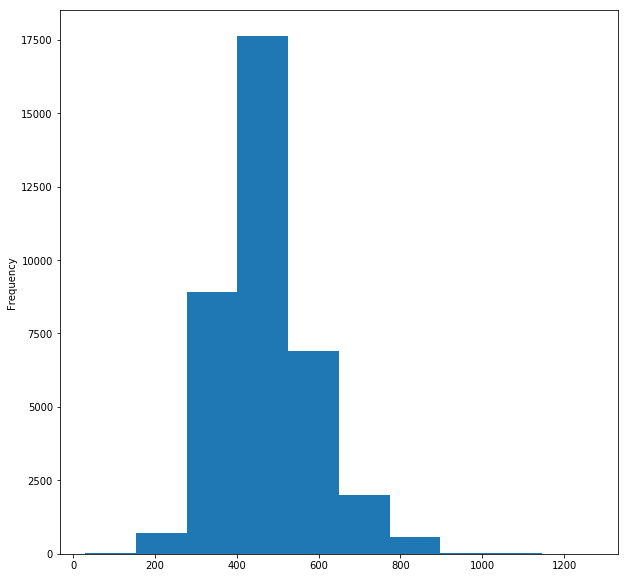

In [6]:
vehiculos['co2'].plot.hist();

Alternativamente, podemos hacer un gráfico KDE , o Kernel Density Estimate, que produce una funcion estimada de la distribución de la variable ([Función de densidad de probabilidad](https://es.wikipedia.org/wiki/Funci%C3%B3n_de_densidad_de_probabilidad)).

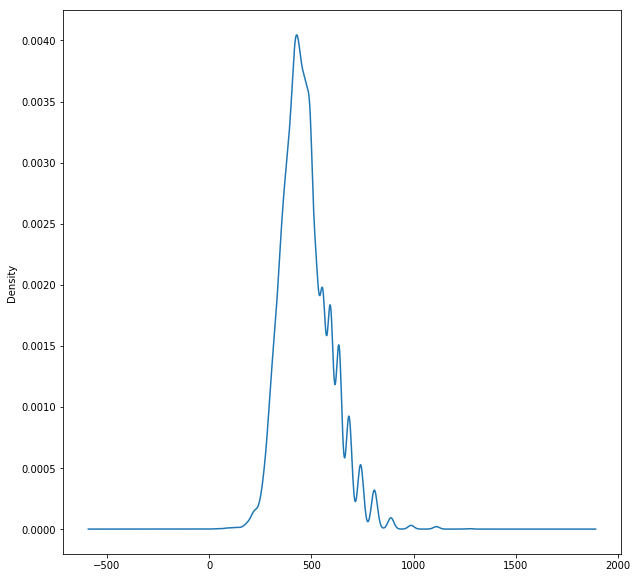

In [7]:
vehiculos['co2'].plot.kde();

In [8]:
def distribucion_variable_numerica(df, col):
    df[col].plot.kde()
    plt.xlabel('Distribucion de la variable {}'.format(col))
    plt.show()

Ahora podemos usar pywidgets para poder analizar las distribuciones más cómodamente. Tiene sentido hacer estos gráficos solo para variables numéricas. El método pandas.select_dtypes devuelve aquellas columnas de unos tipos específicos

In [9]:
columnas_numericas = vehiculos.select_dtypes(['int', 'float']).columns

In [10]:
from ipywidgets import interact, fixed

In [11]:
interact(distribucion_variable_numerica, col=columnas_numericas, df=fixed(vehiculos));

interactive(children=(Dropdown(description='col', options=('year', 'desplazamiento', 'cilindros', 'consumo', '…

Vemos que la variable cilindros pese a ser numérica no tiene una distribución equilibrada de valores

In [12]:
vehiculos['cilindros'].value_counts(normalize=True)

4.0     0.381184
6.0     0.350767
8.0     0.220344
5.0     0.020115
12.0    0.015630
3.0     0.006252
10.0    0.004132
2.0     0.001359
16.0    0.000217
Name: cilindros, dtype: float64

Parece que gran parte de las variables siguen una distribucion normal. Que las variables sigan una distribución normal es importante dado que muchos algoritmos asumen que la distribución de las variables es normal.

La distribucion normal tienen la forma de la linea verde en el siguiente gráfico:

![dnormal](data/dnormal.png)


Podemos comprobar esto con un grafico de probabilidad.

La funcion de scipy.stats probplot compara la distribucion de una variable con una distribucion teorica (la normal por defecto), cuanto más se parezca la gráfica a una linea de 45 grados más normal será

In [17]:
from scipy import stats

In [18]:
def normalidad_variable_numerica(col):
    stats.probplot(vehiculos[col], plot=plt)
    plt.xlabel('Diagrama de Probabilidad(normal) de la variable {}'.format(col))
    plt.show()

In [19]:
interact(normalidad_variable_numerica, col=columnas_numericas);

interactive(children=(Dropdown(description='col', options=('year', 'desplazamiento', 'cilindros', 'consumo', '…

Parece que siguen una distribución normal, no obstante, conviene asegurarse haciendo un test de normalidad. En un test de normalidad, lo que queremos es rechazar la hipótesis nula de que la variable a analizar se ha obtenido de una población que sigue una distribución normal. Para un nivel de confianza de 95%, rechazamos la hipótesis nula si el p-value es inferior a 0.05. Esto es, si se obtiene un valor P (p-value) menor de 0.05, significa que las probabilidades de que la hipótesis nula sean ciertas es tan baja (menos de un 5%) que la rechazamos.

scipy tiene la función normaltest que devuelve el p-value

In [20]:
for num_col in columnas_numericas:
    _, pval = stats.normaltest(vehiculos[num_col])
    if(pval < 0.05):
        print("Columna {} no sigue una distribución normal".format(num_col))

Columna year no sigue una distribución normal
Columna consumo no sigue una distribución normal
Columna co2 no sigue una distribución normal
Columna consumo_litros_milla no sigue una distribución normal


Con lo cual vemos que ninguna de las variables numéricas siguen una distribución normal correcta.

### Ditribución de variables categóricas
Una manera de ver como se distribuyen las variables categóricas es mediante la función `pandas.value_counts`. Dicha función nos devuelve el numero de records existentes para cada valor de una columna

In [21]:
def distribucion_variable_categorica(col):
    vehiculos[col].value_counts(ascending=True,normalize=True).tail(20).plot.barh()
    plt.show()

In [22]:
columnas_categoricas = vehiculos.select_dtypes(['object', 'category']).columns

In [23]:
interact(distribucion_variable_categorica, col=columnas_categoricas);

interactive(children=(Dropdown(description='col', options=('fabricante', 'modelo', 'transmision', 'traccion', …

### Conclusiones

- Ninguna variable numérica sigue una distribución normal

- la variable numérica cilindros tiene una distribución de valores discretos no balanceada (cilindrada de 2 y 4 y 8 suman el 95% de los vehiculos). Podria agruparse como variable categórica (2, 4 , 8 y otro)

- El fabricante con la mayor cantidad de modelos es Chevrolet (10% del total)

- 65% de los vehiculos usan gasolina normal

- La distribución de tamaños de motor y de consumo y co2 está equilibrada en todo el rango

- 70% de los vehiculos usan traccion a las dos ruedas

- dos tercios de los coches tienen transmision automática

- La clase mayoritaria de vehiculos es la de coches pequeños (35% del total)
- Los mayores fabricantes en cuanto a vehiculos analizados son los estadounidenses. Esto tiene sentido ya que la EPA es la agencia americana y probablemente es la que tiene más interes en estudiar coches de USA